If you've completed our Bagging notebooks, you've seen that an ensemble of decision trees can make more accurate predictions than a single decision tree due to reduced variance. If you were hyper-critical of bagging you might ask that if we use the same features for each model and there is a substantial degree of overlap in the training sets for each model as a result of the bootstrapping process, how different are these models? Is each model more or less telling us the same thing?

One alteration we could make to the modelling process to get a more diverse ensemble is to randomly select a different subset of features which we can use to fit each model. For example, if we had ten features at our disposal, for the first tree in the ensemble we could select, say, 3 of the features at random and use them to model the first bootstrapped dataset. For the second tree we would select 3 different features at random to model the second bootstrapped dataset, and so on. 

This approach, known as Random Forests, is different from Bagging in two ways:

1. By using a different feature set for each model, our ensemble is made up of a more diverse set of models, which will hopefully reduce the variance in the bias-variance decompoition more effectively. This increased diversity also reduces our chances of overfitting to the training set.
2. Again by using a different feature set for each model, we can now quantify how important different features are to the fitting process. For example, if we predict values with high accuracy whenever a certain feature is included in a model, and all of the other models in our ensemble predict poorly, then we could conclude that that feature is essential to accurately modelling the target variable.





# Understanding Decision Trees

The main challenge in understanding Random Forests (and Bagging) is in understanding the underlying Decision Trees which they use to make predictions. If you've not already done so, **I would strongly recommend heading over to our notebooks on Decision Trees and becoming familiar with how they work.** The main purpose of this notebook is to help you understand how to create an ensemble of models and provide them with different features, therefore we provide a complete implementation of a Decision Tree for you to use here.

# Overlap with the Bagging notebook

Since Bagging is essentially a special case of Random Forests (where the number of randomly chosen features is equal to the total number of available features), this notebook is very similar to the bagging notebook - in fact there is only one additional line in the Random Forests notebook, that which chooses a random subset of the parameters. 

I personally think it makes most sense to become familiar with Decision Trees, then extend that idea to Bagging to see how an ensemble of models affects performance, because we can do that when using a single feature (unlike with Random Forests), making visualisation easier, which is why I made a Bagging notebook. I also understand that most people are probably more interested from a practical standpoint in using Random Forests, given their wider use in the real world, which is how we've ended up with two such similar notebooks.

# Import Python Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
from random import sample

# Generate data for Random Forest

(We'll use a different data generation process to bagging as we want a larger feature set. This is the same data generation process that we used in the Linear Regression Notebook)

In [2]:
n = 1000 #Number of observations in the training set
p = 10 #Number of parameters, including intercept

#Assign True parameters to be estimated
beta = np.random.uniform(-10, 10, p) #Randomly initialise true parameters
print(beta)

[ 8.46073265 -2.84287558  3.02975706  8.56207685 -8.75208537  3.6294244
  3.91028463 -3.0693924   4.57458108 -0.16189489]


In [3]:
X = np.random.uniform(0,10,(n,(p-1))) 
X0 = np.array([1]*n).reshape((n,1)) #Columns for intercept

X = np.concatenate([X0,X], axis = 1) #Join intercept to other variables to form feature matrix

In [4]:
Y = np.matmul(X,beta) + np.random.normal(0,10,n) #Linear combination of the features plus a normal error term

In [5]:
#Concatenate to create dataframe

dataFeatures = pd.DataFrame(X)
dataFeatures.columns = [f'X{i}' for i in range(p)]

dataTarget = pd.DataFrame(Y)
dataTarget.columns = ['Y']

data = pd.concat([dataFeatures, dataTarget], axis = 1)


In [6]:
data.head()

X0        X1        X2        X3        X4        X5        X6        X7  \
0  1.0  6.524159  6.823382  7.556091  3.489933  4.138729  3.032271  7.346027   
1  1.0  6.039844  9.369225  8.127892  2.859617  5.173386  9.530207  6.898767   
2  1.0  6.273619  8.043968  6.346794  5.516107  7.436557  8.779798  1.372985   
3  1.0  4.188903  2.193960  6.507476  4.288049  6.883521  6.467496  5.997722   
4  1.0  0.200500  7.058754  7.262732  8.938908  3.297284  9.077784  3.670546   

         X8        X9           Y  
0  7.763316  9.884973   82.333238  
1  6.364690  8.763996  128.607999  
2  4.103695  7.142029  119.376043  
3  2.590132  6.899091   50.782161  
4  1.123142  2.348250   35.359799

Note that the feature $X_0$ is always equal to one - this was the intercept term in our linear regression set up.

# Implementing the Random Forests model 

As mentioned above the random forests implementation is almost identical to the bagging implementation, the only significant difference being an added line in the fitRF (called fitBaggedDT in the bagged implementation) method

In [7]:
class decisionTreeNode:
    
    def __init__(self,data, target, features, currentDepth): 
        self.left = None #Left child node
        self.right = None #Left child node
        self.currentDepth = currentDepth
        self.data = data 
        self.target = target
        self.features = features
        
        
        self.splitPointMesh = {}
        
        for feature in self.features:
            #We have a set of features and to determine how we're going to split this dataset 
            #we'll go through each feature in turn and find an optimal split point for that feature
            #Then we'll split using the feature which gives the smallest error for the dataset
            #(This is not necessarily an optimal strategy but the combinatorial space is too big to 
            #investigate every possible tree)
            
            #So the first point of that is defining a mesh for each feature
            
#             meshMin = np.sort(self.data[feature])[1] 
#             meshMax = np.sort(self.data[feature])[-2]

            meshMin = np.min(self.data[feature])
            meshMax = np.max(self.data[feature])
            self.splitPointMesh[feature] = np.linspace(meshMin, meshMax, 500)
    
    def computeMeansGivenSplitPoint(self, splitPoint, feature):
        #Given a split point, we want to split the training set in two
        #One containing all the points below the split point and one containing all the points above the split point
        #The means are then the means of the targets in those datasets and they are the values we want to return
        
        belowSplitPoint = self.data.loc[self.data[feature] < splitPoint][self.target].mean()
        aboveSplitPoint = self.data.loc[self.data[feature] >= splitPoint][self.target].mean()
        
        return belowSplitPoint, aboveSplitPoint
    
    def computeSquaredError(self, splitPoint, feature):
        #Once we have a split point and a set of means, we need to have some way of identifying whether it's 
        #a good split point or not
        
        #First apply compuuteMeansGivenSplitPoint to get the values for above and below the dataset
        #Then compute the sum of squared errors yielded by assigning the corresponding mean to each point in the training set
        #If we add these two sums of squares together then we have a single error number which indicates how good our split point is
        
        c0, c1 = self.computeMeansGivenSplitPoint(splitPoint, feature)
        
        #To get the value of errorBelow, subset the training set to the points below the split points
        #Then calculate the squared difference between target and c0 for each observation in the subset
        #Then sum them up (This can all be done in one line)
        
        errorBelow = np.sum((self.data.loc[self.data[feature] < splitPoint][self.target] - c0)**2) 
        
        #errorAbove works in the same way
        errorAbove = np.sum((self.data.loc[self.data[feature] >= splitPoint][self.target] - c1)**2) 
        
        totalError = errorBelow + errorAbove

        return totalError
    
    def createSplitDatasetsGivenSplitPointAndFeature(self, splitPoint, feature):
        #Given a split point, split the dataset up and return two datasets
        
        belowData = self.data.loc[self.data[feature] < splitPoint]
        aboveData = self.data.loc[self.data[feature] >= splitPoint]
        
        return belowData, aboveData
    

def fitDT(Node, maxDepth):
    
    
    if Node.currentDepth < maxDepth:
        #if node depth > max depth then we continue to split
        
        #Do splitting here
        #We want to find the best error for each of the features, then use that feature to do the splitting
        
        errors = {}
        for feature in Node.features:
            errors[feature] = [Node.computeSquaredError(splitPoint, feature) for splitPoint in Node.splitPointMesh[feature]]
            
        #Now we want to extract the feature and splitPoint which gave the best overall error
        currentBestError = min(errors[Node.features[0]]) + 1 #Initialise
        
        for feature in Node.features:
            if min(errors[feature]) < currentBestError:
                bestFeature = feature
                currentBestError = min(errors[feature])
                bestSplitPoint = Node.splitPointMesh[feature][np.argmin(errors[feature])]
                
                
        #Now we have the best feature to split on and the place where we should split it
        splitDataLeft, splitDataRight = Node.createSplitDatasetsGivenSplitPointAndFeature(bestSplitPoint, bestFeature)
        
        #Record the splitting process
        Node.featureSplitOn = bestFeature
        Node.bestSplitPoint = bestSplitPoint
        #print(bestFeature, bestSplitPoint)
        
        
        
        
        if Node.data.drop_duplicates().shape[0] > 1:
            Node.left = decisionTreeNode(splitDataLeft, Node.target, Node.features, Node.currentDepth + 1) #Define nodes on the levels below (increment depth by 1)
            Node.right = decisionTreeNode(splitDataRight, Node.target, Node.features, Node.currentDepth + 1)
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
        else: #If there is only one example left in this dataset then there's no need to do any splitting
            Node.left = copy.deepcopy(Node) #Note deepcopy of the node instance
            Node.right = copy.deepcopy(Node)
            Node.left.currentDepth = Node.currentDepth + 1
            Node.right.currentDepth = Node.currentDepth + 1
            fitDT(Node.left, maxDepth) #The recursive part, which works exactly the same as we saw for the simpler example above
            fitDT(Node.right, maxDepth)
            
        
    elif Node.currentDepth == maxDepth:
        #If we're at a terminal node then we need to return a value to predict
        #Don't need to do any splitting or anything like that, just want to return the mean value
        
        Node.prediction = Node.data[Node.target].mean()
            
def predictSingleExample(decisionTreeNode, xrow, maxDepth):
    #decisionTreeNode should be the root node of a fitted decision tree
    #maxDepth needs to be the same maxDepth as the fitted decision tree
    
    #x needs to be a pandas dataframe (with one or more rows) with the same column names as the features 
    #in the training set
    
    if decisionTreeNode.currentDepth < maxDepth:

        if xrow[decisionTreeNode.featureSplitOn] < decisionTreeNode.bestSplitPoint:
            return predictSingleExample(decisionTreeNode.left, xrow, maxDepth)
        else:
            return predictSingleExample(decisionTreeNode.right, xrow, maxDepth)
     

    elif decisionTreeNode.currentDepth == maxDepth:
        return decisionTreeNode.prediction

In [8]:
class randomForest:
    
    def __init__(self, data, target, features, trainTestRatio = 0.9, maxDepth = 5):
        #data - a pandas dataset 
        #target - the name of the pandas column which contains the true labels
        #feature - the name of the pandas column which we will use to do the regression
        #trainTestRatio - the proportion of the entire dataset which we'll use for training
                    #   - the rest will be used for testing
        
        self.target = target
        self.features = features
        
        #Max Depth of decision tree
        self.maxDepth = maxDepth
        
        #Split up data into a training and testing set
        self.train, self.test = train_test_split(data, test_size=1-trainTestRatio) #We're doing the train/test split here
                                                                                 #Instead of in the DT
            
    
    def fitRF(self, numTrees = 50, numTreeFeatures = None):
        
        if numTreeFeatures is None:
            numTreeFeatures = int(np.ceil(np.sqrt(len(self.features)))) #Default value for number of features selected at random
        
        self.forest = [] #List containing all of our decision trees
        
        for i in range(numTrees):
            
            if i % 1 == 0:
                print(f'Fitting decision Tree {i+1} of {numTrees}')
            
            #Bootstrap dataframe
            bootstrappedData = self.train.sample(frac = 1, replace = True)
            
            #Randomly select a subset of the predictors
            rf_features = sample(self.features, numTreeFeatures)
            
            #Define a decision tree
            root = decisionTreeNode(bootstrappedData, self.target, rf_features, 0) #Define root
            fitDT(root, self.maxDepth)
            
            self.forest.append(copy.deepcopy(root)) #Save the fitted decision tree in the forest
            
        return 0
    
    def predict(self, X):
        #X should be a pandas dataframe
        
        return np.mean(np.array([[predictSingleExample(root, row, self.maxDepth) for index, row in X.iterrows()] for root in self.forest]), axis = 0)


### Implement a Random Forest with 25 trees

It might take some time for the model to fit, as our implementation is less efficient than the ones in Python machine learning libraries!

In [9]:
rf = randomForest(data, 'Y', [f'X{i}' for i in range(len(list(data.columns)) - 1)], maxDepth = 3)
rf.fitRF(numTrees = 25)

Fitting decision Tree 1 of 25
Fitting decision Tree 2 of 25
Fitting decision Tree 3 of 25
Fitting decision Tree 4 of 25
Fitting decision Tree 5 of 25
Fitting decision Tree 6 of 25
Fitting decision Tree 7 of 25
Fitting decision Tree 8 of 25
Fitting decision Tree 9 of 25
Fitting decision Tree 10 of 25
Fitting decision Tree 11 of 25
Fitting decision Tree 12 of 25
Fitting decision Tree 13 of 25
Fitting decision Tree 14 of 25
Fitting decision Tree 15 of 25
Fitting decision Tree 16 of 25
Fitting decision Tree 17 of 25
Fitting decision Tree 18 of 25
Fitting decision Tree 19 of 25
Fitting decision Tree 20 of 25
Fitting decision Tree 21 of 25
Fitting decision Tree 22 of 25
Fitting decision Tree 23 of 25
Fitting decision Tree 24 of 25
Fitting decision Tree 25 of 25


0

### Let's see how we did by plotting our predicted values against the true values in the test set

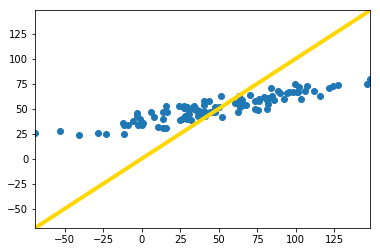

In [10]:
testPred = rf.predict(rf.test[[f'X{i}' for i in range(len(list(data.columns)) - 1)]]) #Obtain predictions on test set
plt.scatter(rf.test['Y'], testPred)

minLim = min(min(rf.test['Y']), min(testPred))
maxLim = max(max(rf.test['Y']), max(testPred))


plt.plot(np.arange(minLim, maxLim, 1), np.arange(minLim, maxLim, 1), color = 'gold', linewidth = 4) #Line y = x for comparison

#Set axes 
plt.xlim((minLim,maxLim))
plt.ylim((minLim,maxLim))

plt.show()


### Whilst the model hasn't performed disastrously, there is definitely a tendency to underpredict the larger values and overpredict the smaller ones

We could say that the model is relying too much on the overall average of the data and not effectively discriminating between different regions of the feature space.

With Random Forests, this issue can often be solved by tweaking the model hyperparameters, i.e. adding more trees to our ensemble and increasing the max depth of the constituent decision trees. Given that our implementation is quite a bit slower than the sklearn implementation we're going to use their implementation to see if this is indeed the case - in principle you should be able to obtain the same results using our implementation (and if you want to do that I admire your patience!)

### Increasing the number of trees in our forest

First let's verify that the sklearn implementation of the Random Forest gives comparable results to our own using the parameters that we used:

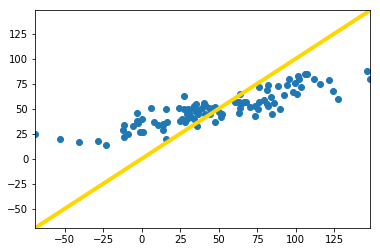

In [11]:
from sklearn.ensemble import RandomForestRegressor
skrf = RandomForestRegressor(n_estimators=25, max_depth=3, max_features='sqrt') #This is the same architecture we were using
skrf.fit(rf.train[rf.features], rf.train[rf.target]) #fit the model using out training data

minLim = min(min(rf.test['Y']), min(skrf.predict(rf.test[rf.features])))
maxLim = max(max(rf.test['Y']), max(skrf.predict(rf.test[rf.features])))


plt.scatter(rf.test['Y'], skrf.predict(rf.test[rf.features]))
plt.plot(np.arange(minLim, maxLim, 1), np.arange(minLim, maxLim, 1), color = 'gold', linewidth = 4) #Line y = x for comparison

#Set axes 
plt.xlim((minLim,maxLim))
plt.ylim((minLim,maxLim))

plt.show()


As with our own implementation with 25 trees and a maximum tree depth of 3, we tend to significantly overestimate the smaller labels and underestimate the larger ones.

In [12]:
#Add more trees, and allow them to be deeper.
skrfBigger = RandomForestRegressor(n_estimators=2000, max_depth=9, max_features='auto')

In [13]:
skrfBigger.fit(rf.train[rf.features], rf.train[rf.target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

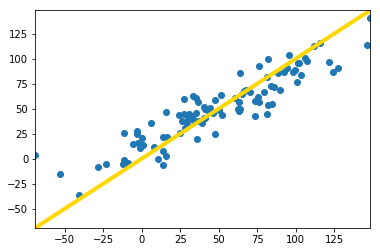

In [14]:
plt.scatter(rf.test['Y'], skrfBigger.predict(rf.test[rf.features]))

minLim = min(min(rf.test['Y']), min(skrfBigger.predict(rf.test[rf.features])))
maxLim = max(max(rf.test['Y']), max(skrfBigger.predict(rf.test[rf.features])))



plt.plot(np.arange(minLim, maxLim, 1), np.arange(minLim, maxLim, 1), color = 'gold', linewidth = 4) #Line y = x for comparison

#Set axes
plt.xlim((minLim,maxLim))
plt.ylim((minLim,maxLim))

plt.show()


## In this case we can see that increasing the complexity of the model allows us to achieve a good fit

The line y=x runs through the centre of the point cloud indicating that, most of the time, the model is accurately predicting the label